# 简单轨迹追踪演示
使用TinyMPC硬件求解器追踪圆形轨迹

In [1]:
import os
os.chdir("/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/")


import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 导入dynamics模块
from dynamics import LinearizedQuadcopterDynamics, CrazyflieParams, NoiseModel

# 导入硬件求解器
sys.path.append('driver')
from tinympc_hw import tinympc_hw

print("所有模块导入成功")

所有模块导入成功


## 1. 初始化系统参数

In [2]:
# 系统参数
control_freq = 100.0  # 控制频率 Hz
dt = 1.0 / control_freq
sim_duration = 15.0  # 仿真时间 秒
N = int(sim_duration * control_freq)  # 总步数
horizon = 5  # MPC预测域

# 初始化动力学模型
params = CrazyflieParams()
noise_model = NoiseModel()
dynamics = LinearizedQuadcopterDynamics(params, noise_model)

# 生成系统矩阵
A, B = dynamics.generate_system_matrices(control_freq)
Q, R = dynamics.generate_cost_matrices()
constraints = dynamics.generate_constraints()

print(f"系统维度: nx={A.shape[0]}, nu={B.shape[1]}")
print(f"控制频率: {control_freq} Hz")
print(f"预测域: {horizon}")

系统维度: nx=12, nu=4
控制频率: 100.0 Hz
预测域: 5


## 2. 生成圆形参考轨迹

参考轨迹生成完成: (12, 1500)
轨迹半径: 1.5 m
轨迹高度: 1.2 m


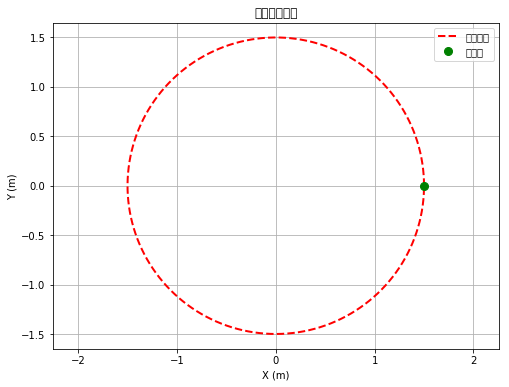

In [3]:
# 圆形轨迹参数
radius = 1.5  # 半径
center = [0, 0, 1.2]  # 圆心
omega = 2 * np.pi / sim_duration  # 角速度

# 生成时间序列
t = np.linspace(0, sim_duration, N)

# 生成参考轨迹 (12维状态)
X_ref = np.zeros((12, N))
X_ref[0, :] = center[0] + radius * np.cos(omega * t)  # x
X_ref[1, :] = center[1] + radius * np.sin(omega * t)  # y  
X_ref[2, :] = center[2]  # z (恒定高度)
X_ref[6, :] = -radius * omega * np.sin(omega * t)  # vx
X_ref[7, :] = radius * omega * np.cos(omega * t)   # vy
X_ref[8, :] = 0  # vz
# 其他状态保持0

# 参考控制输入 (悬停)
U_ref = np.zeros((4, N-1))

print(f"参考轨迹生成完成: {X_ref.shape}")
print(f"轨迹半径: {radius} m")
print(f"轨迹高度: {center[2]} m")

# 可视化参考轨迹
plt.figure(figsize=(8, 6))
plt.plot(X_ref[0, :], X_ref[1, :], 'r--', linewidth=2, label='参考轨迹')
plt.plot(X_ref[0, 0], X_ref[1, 0], 'go', markersize=8, label='起始点')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('圆形参考轨迹')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## 3. 初始化硬件求解器

In [4]:
# 查找可用的bitstream文件
bitstream_files = []
for file in os.listdir('.'):
    if file.endswith('.bit'):
        bitstream_files.append(file)

print(f"找到的bitstream文件: {bitstream_files}")

# 初始化硬件求解器
bitstream_path = "/home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit"
mpc_hw = tinympc_hw(bitstream_path=bitstream_path)

use_hardware = True

找到的bitstream文件: []
Loading overlay from: /home/xilinx/jupyter_notebooks/zhenyu/tinympc_ip_gen/bitstream/tinympcproj_N5_100Hz_float.bit
Setting FCLK0 frequency from 99.999 MHz to 250 MHz
Clock frequency set to 249.9975 MHz
Found TinyMPC IP core: tinympc_solver_0
Allocated 164 float32 memory buffer at 0x0103a000
IP core initialized with memory address: 0x000000000103a000
  Lower 32 bits: 0x0103a000
  Upper 32 bits: 0x00000000
TinyMPC driver initialized successfully


## 4. 运行轨迹追踪仿真

In [5]:
# 初始化仿真状态
x_current = X_ref[:, 0] + np.random.normal(0, 0.1, 12)  # 初始状态 (加一点噪声)
x_current[2] = max(x_current[2], 0.5)  # 确保不在地面以下

# 存储历史数据
x_history = [x_current.copy()]
u_history = []

print(f"开始仿真，总共 {N-1} 步...")
print(f"初始位置: [{x_current[0]:.3f}, {x_current[1]:.3f}, {x_current[2]:.3f}]")

# 仿真循环
for step in range(N-1):
    # 获取当前时刻的参考轨迹段
    X_ref_horizon = np.zeros((12, horizon))
    U_ref_horizon = np.zeros((4, horizon-1))
    
    for i in range(horizon):
        ref_idx = min(step + i, N-1)
        X_ref_horizon[:, i] = X_ref[:, ref_idx]
    
    # 求解MPC问题
    if use_hardware and mpc_hw is not None:
        try:
            # 设置问题数据
            mpc_hw.set_x0(x_current)
            mpc_hw.set_x_ref(X_ref_horizon.T)  # 转置为 (N, nx)
            mpc_hw.set_u_ref(U_ref_horizon.T)  # 转置为 (N-1, nu)
            
            # 求解
            success = mpc_hw.solve(timeout=1.0)
            
            if success and mpc_hw.solved:
                u_control = mpc_hw.u[0, :] if len(mpc_hw.u) > 0 else np.zeros(4)
            else:
                u_control = np.zeros(4)  # 悬停控制
        except Exception as e:
            if step < 5:  # 只在前几步显示错误
                print(f"步骤 {step} 硬件求解错误: {e}")
            u_control = np.zeros(4)
    else:
        # 简单的软件仿真 (PD控制器)
        ref_pos = X_ref[:3, step]
        ref_vel = X_ref[6:9, step]
        
        pos_error = ref_pos - x_current[:3]
        vel_error = ref_vel - x_current[6:9]
        
        # 简单PD控制
        kp = 2.0
        kd = 1.0
        u_control = np.array([
            params.mass * params.gravity + kp * pos_error[2] + kd * vel_error[2],  # thrust
            kp * pos_error[1] + kd * vel_error[1],  # roll torque
            kp * pos_error[0] + kd * vel_error[0],  # pitch torque  
            0.0  # yaw torque
        ])
    
    # 添加执行器噪声
    u_noisy = u_control * (1 + np.random.normal(0, 0.02, 4))
    
    # 前向仿真
    process_noise = np.random.normal(0, noise_model.get_state_noise_std(dt))
    gravity_disturbance = getattr(dynamics, 'gravity_disturbance', np.zeros(12))
    x_next = A @ x_current + B @ u_noisy + process_noise + gravity_disturbance
    
    # 应用约束
    x_next = np.clip(x_next, constraints['x_min'], constraints['x_max'])
    
    # 存储历史
    x_current = x_next
    x_history.append(x_current.copy())
    u_history.append(u_control.copy())
    
    # 显示进度
    if (step + 1) % 50 == 0:
        pos_error = np.linalg.norm(x_current[:3] - X_ref[:3, step])
        print(f"步骤 {step+1}/{N-1}, 位置误差: {pos_error:.4f} m")

print("仿真完成！")

# 转换为numpy数组
x_history = np.array(x_history)
u_history = np.array(u_history)

print(f"实际轨迹形状: {x_history.shape}")
print(f"控制输入形状: {u_history.shape}")

开始仿真，总共 1499 步...
初始位置: [1.678, -0.144, 1.196]
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 7 polls
Hardware execution completed in 0.0022 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0018 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0016 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idle: True)
IP started...
IP completed after 8 polls
Hardware execution completed in 0.0016 seconds
Parameters written: max_iter=100, check_termination_iter=10
Before start - Control: 0x00000004 (ready: False, idl

## 5. 可视化轨迹追踪结果

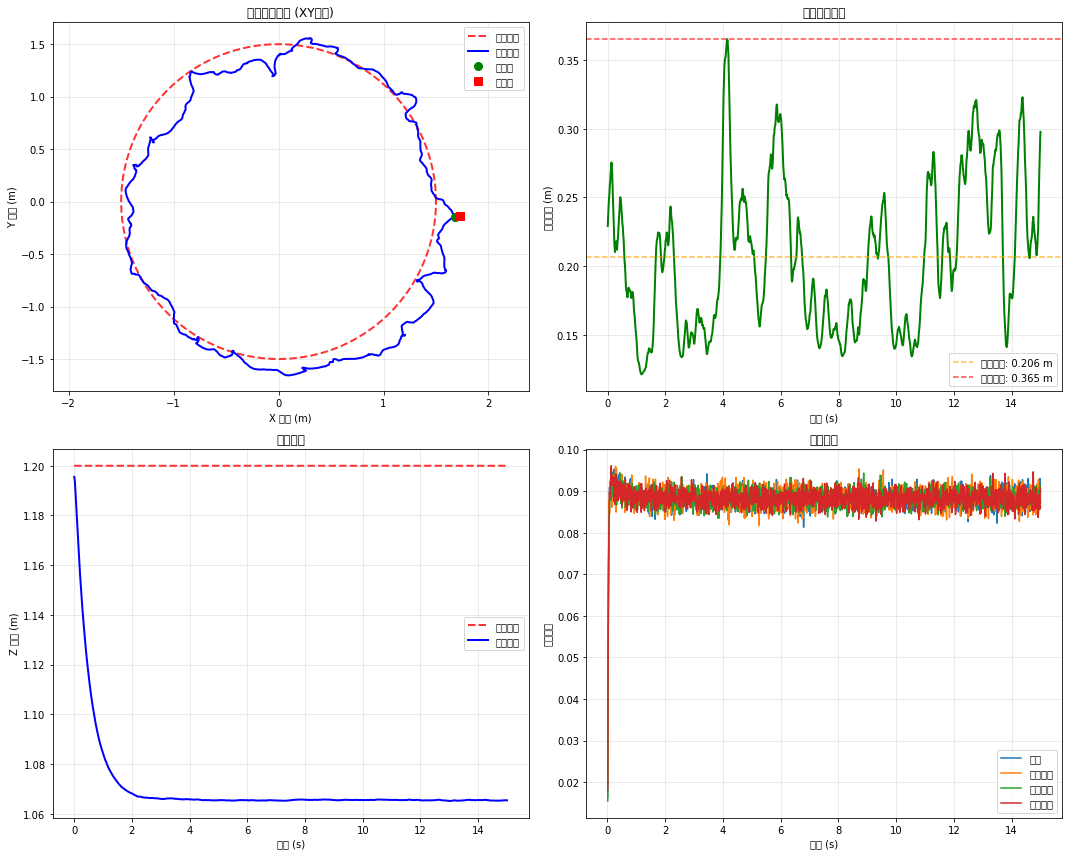


=== 轨迹追踪性能统计 ===
仿真时长: 15.0 秒
仿真步数: 1500 步
求解器类型: 硬件
最终位置误差: 0.2978 m
平均位置误差: 0.2065 m
最大位置误差: 0.3652 m
位置误差标准差: 0.0540 m
轨迹完成误差: 0.2978 m

硬件求解器信息:
  最大迭代次数: 100
  终止检查间隔: 10


In [6]:
# 创建综合可视化
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. XY轨迹对比
ax1.plot(X_ref[0, :], X_ref[1, :], 'r--', linewidth=2, label='参考轨迹', alpha=0.8)
ax1.plot(x_history[:, 0], x_history[:, 1], 'b-', linewidth=2, label='实际轨迹')
ax1.plot(x_history[0, 0], x_history[0, 1], 'go', markersize=8, label='起始点')
ax1.plot(x_history[-1, 0], x_history[-1, 1], 'rs', markersize=8, label='结束点')
ax1.set_xlabel('X 位置 (m)')
ax1.set_ylabel('Y 位置 (m)')
ax1.set_title('轨迹追踪结果 (XY视图)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# 2. 位置误差
position_errors = []
for i in range(len(x_history)):
    ref_idx = min(i, X_ref.shape[1]-1)
    error = np.linalg.norm(x_history[i, :3] - X_ref[:3, ref_idx])
    position_errors.append(error)

time_vec = np.linspace(0, sim_duration, len(position_errors))
ax2.plot(time_vec, position_errors, 'g-', linewidth=2)
ax2.set_xlabel('时间 (s)')
ax2.set_ylabel('位置误差 (m)')
ax2.set_title('位置跟踪误差')
ax2.grid(True, alpha=0.3)

# 添加误差统计
mean_error = np.mean(position_errors)
max_error = np.max(position_errors)
ax2.axhline(y=mean_error, color='orange', linestyle='--', alpha=0.7, 
           label=f'平均误差: {mean_error:.3f} m')
ax2.axhline(y=max_error, color='red', linestyle='--', alpha=0.7,
           label=f'最大误差: {max_error:.3f} m')
ax2.legend()

# 3. 高度追踪
ax3.plot(time_vec, X_ref[2, :len(time_vec)], 'r--', linewidth=2, label='参考高度', alpha=0.8)
ax3.plot(time_vec, x_history[:, 2], 'b-', linewidth=2, label='实际高度')
ax3.set_xlabel('时间 (s)')
ax3.set_ylabel('Z 位置 (m)')
ax3.set_title('高度追踪')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 控制输入
if len(u_history) > 0:
    control_time = time_vec[1:len(u_history)+1]
    ax4.plot(control_time, u_history[:, 0], label='推力', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 1], label='滚转力矩', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 2], label='俯仰力矩', linewidth=1.5)
    ax4.plot(control_time, u_history[:, 3], label='偏航力矩', linewidth=1.5)
    ax4.set_xlabel('时间 (s)')
    ax4.set_ylabel('控制信号')
    ax4.set_title('控制输入')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印性能统计
print(f"\n=== 轨迹追踪性能统计 ===")
print(f"仿真时长: {sim_duration:.1f} 秒")
print(f"仿真步数: {len(x_history)} 步")
print(f"求解器类型: {'硬件' if use_hardware else '软件PD控制'}")
print(f"最终位置误差: {position_errors[-1]:.4f} m")
print(f"平均位置误差: {mean_error:.4f} m")
print(f"最大位置误差: {max_error:.4f} m")
print(f"位置误差标准差: {np.std(position_errors):.4f} m")

# 计算轨迹完成度
final_pos = x_history[-1, :3]
target_pos = X_ref[:3, -1]
completion_error = np.linalg.norm(final_pos - target_pos)
print(f"轨迹完成误差: {completion_error:.4f} m")

if use_hardware and mpc_hw is not None:
    print(f"\n硬件求解器信息:")
    print(f"  最大迭代次数: {mpc_hw.max_iter}")
    print(f"  终止检查间隔: {mpc_hw.check_termination}")

## 总结

这个简单的demo演示了:
1. 使用TinyMPC硬件求解器进行实时轨迹追踪
2. 圆形参考轨迹的生成和追踪
3. 轨迹追踪性能的可视化分析
4. 硬件求解器和软件fallback的切换

如果硬件求解器不可用，系统会自动切换到简单的PD控制器作为软件仿真。